In [9]:
from google.colab import files
uploaded = files.upload()

Saving aclImdb_v1.tar.gz to aclImdb_v1.tar.gz


In [10]:
!ls

aclImdb_v1.tar.gz  sample_data


In [11]:
!tar -xzvf "aclImdb_v1.tar.gz" 

Streaming af output blev afkortet til de sidste 5000 linjer.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/tra

In [12]:
!ls

aclImdb  aclImdb_v1.tar.gz  sample_data


In [13]:
# -*- coding: utf-8 -*-
"""
Created on Mon April 6 14:43:11 2020
@author: Sila
"""

# Slightly changed version of
# Petr Baudis and Martin Holecek tutorial from MLPrague 2018
# for information extraction from documents.

# Vocabulary: All words used, starting by the most frequent
with open('aclImdb/imdb.vocab','r',encoding='utf-8')as f:
    vocab = [word.rstrip() for word in f]
    # Keep only most frequent 5000 words rather than all 90000
    # Just saving memory - the long tail occurs too few times
    # for the model to learn anything anyway
    vocab = vocab[:5000]
    print('%d words in vocabulary' % (len(vocab),))

5000 words in vocabulary


In [14]:
import re

def text_tokens(text):
    text = text.lower()
    text = re.sub("\\s", " ", text)
    text = re.sub("[^a-zA-Z' ]", "", text)
    tokens = text.split(' ')
    return tokens

import os

In [15]:
def load_dataset(dirname):
    X, y = [], []
    # Review files: neg/0_3.txt neg/10000_4.txt neg/10001_4.txt ...
    for y_val, y_label in enumerate(['neg', 'pos']):
        y_dir = os.path.join(dirname, y_label)
        for fname in os.listdir(y_dir):
            fpath = os.path.join(y_dir, fname)
            # print('\r' + fpath + '   ', end='')
            with open(fpath, 'r',encoding='utf-8') as f:
                tokens = text_tokens(f.read())
            X.append(tokens)
            y.append(y_val)  # 0 for 'neg', 1 for 'pos'
    print()
    return X, y

print("Load training set:")
X_train, y_train = load_dataset('aclImdb/train/')

Load training set:



In [16]:
# We are cheating here - this is a test set, not a validation set.
# This is just to make results quickly comparable to outside results
# during the tutorial, but you should normally never use the test set
# during training, of course!
print("Load test set:")
X_val, y_val = load_dataset('aclImdb/test/')

print( len(X_train), len(X_val) )

Load test set:

25000 25000


In [17]:
#A one hot encoding is a representation of categorical variables as binary vectors.
# This first requires that the categorical values be mapped to integer values.
# Then, each integer value is represented as a binary vector that is
# all zero values except the index of the integer, which is marked with a 1.
def bow_onehot_vector(tokens):
    vector = [0] * len(vocab)
    for t in tokens:
        try:
            vector[vocab.index(t)] = 1
        except:
            pass  # ignore missing words
    return vector

import sklearn
from sklearn.model_selection import train_test_split

In [18]:
# Only using 20 percent of the data
X_train_using, X_train_notusing, y_train_using, y_train_notusing= train_test_split(X_train, y_train, test_size=0.8)
X_val_using, X_val_notusing, y_val_using, y_val_notusing= train_test_split(X_val, y_val, test_size=0.8)

#Create BOW vectors.
print("Creating BOW vectors")
X_bow_train = [bow_onehot_vector(x) for x in X_train_using]
X_bow_val = [bow_onehot_vector(x) for x in X_val_using]

print("Start fitting model")
def best_train_history(history):
    best_epoch = np.argmax(history.history['val_accuracy'])
    print('Accuracy (epoch %d): %.4f train, %.4f val' % \
          (best_epoch + 1, history.history['accuracy'][best_epoch], history.history['val_accuracy'][best_epoch]))


Creating BOW vectors
Start fitting model


In [19]:
from keras.layers import Activation, Dense, Input
from keras.models import Model
import numpy as np

In [20]:
class BOWSentimentModel(object):
    def __init__(self):
        bow = Input(shape=(len(vocab),), name='bow_input')
        # weights of all inputs
        sentiment = Dense(1)(bow)
        # normalize to [0, 1] range
        sentiment = Activation('sigmoid')(sentiment)

        self.model = Model(inputs=[bow], outputs=[sentiment])
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X), y, validation_data=(np.array(X_val), y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))

In [22]:
sentiment = BOWSentimentModel()
history = sentiment.train( np.array(X_bow_train),  np.array(y_train_using),  np.array(X_bow_val),  np.array(y_val_using))
best_train_history(history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bow_input (InputLayer)      [(None, 5000)]            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5001      
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________
Fitting...
Epoch 1/10
157/157 [==============================] - 2s 6ms/step - loss: 0.6025 - accuracy: 0.7244 - val_loss: 0.5327 - val_accuracy: 0.8154
Epoch 2/10
157/157 [==============================] - 1s 5ms/step - loss: 0.4571 - accuracy: 0.8640 - val_loss: 0.4619 - val_accuracy: 0.8454
Epoch 3/10
157/157 [======

In [24]:
test_text = 'The movie is overflowing with life, rich with all the grand emotions and vital juices of existence, up to and including blood. Without a doubt, one of the best films of all time. As far as crime drama/mobster genre goes, it starts and ends with this masterpiece. For those who have already witnessed the rise and fall of the Corleone family, which mirrors the trajectory of the American dream, now is as good a time as ever to revisit. For those who havent seen Coppolas mafia movies: brace yourselves. This is it.'
test_tokens = text_tokens(test_text)
print(test_text, sentiment.predict([bow_onehot_vector(test_tokens)])[0])

test_text = 'On a journey to San Francisco, Richard, his father and a girl are shipwrecked. The two children escape while their father is on another lifeboat. Come to an island. And then nothing happens for 2 hours. I have never been so bored in my life. Repeat, nothing happes.  The children fish and build huts. But just isnt very exciting to watch. Some people actually fell asleep in their seats next to me. The only thing that kept me from walking out was the fact that it was raining outside.'
test_tokens = text_tokens(test_text)
print(test_text, sentiment.predict([bow_onehot_vector(test_tokens)])[0])

1/1 [==============================] - 0s 21ms/step
The movie is overflowing with life, rich with all the grand emotions and vital juices of existence, up to and including blood. Without a doubt, one of the best films of all time. As far as crime drama/mobster genre goes, it starts and ends with this masterpiece. For those who have already witnessed the rise and fall of the Corleone family, which mirrors the trajectory of the American dream, now is as good a time as ever to revisit. For those who havent seen Coppolas mafia movies: brace yourselves. This is it. [0.8452271]
1/1 [==============================] - 0s 20ms/step
On a journey to San Francisco, Richard, his father and a girl are shipwrecked. The two children escape while their father is on another lifeboat. Come to an island. And then nothing happens for 2 hours. I have never been so bored in my life. Repeat, nothing happes.  The children fish and build huts. But just isnt very exciting to watch. Some people actually fell asle

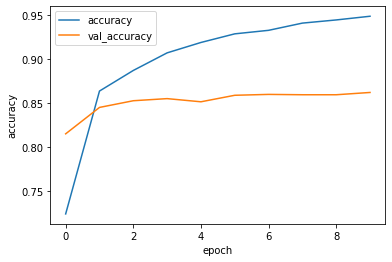

In [25]:
import matplotlib.pyplot as plt
def plot_train_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()

plot_train_history(history)